# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play
from shennong.audio import Audio
from shennong.features.processor.mfcc import MfccProcessor
from shennong.features.postprocessor.delta import DeltaPostProcessor
from shennong.features.postprocessor.cmvn import CmvnPostProcessor
from progress.bar import Bar
from datetime import datetime
from nltk import word_tokenize
import nltk
nltk.download('punkt')
import Levenshtein as lev
import pickle

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)
[nltk_data] Downloading package punkt to /home/josh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Extract features

In [3]:
def get_mfcc_dd(wav_fn):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    audio = Audio.load(wav_fn)
    processor = MfccProcessor(sample_rate=audio.sample_rate, window_type="hamming",frame_length=0.025, frame_shift=0.01,
                              cepstral_lifter=26.0,low_freq=0, vtln_low=60, vtln_high=7200, high_freq=audio.sample_rate/2)
    d_processor = DeltaPostProcessor(order=2)
    mfcc_static = processor.process(audio.channel(1), vtln_warp=1.0)
    mfcc_deltas = d_processor.process(mfcc_static)
    #print(mfcc_static.shape, mfcc_deltas.shape)
    features = mfcc_deltas._to_dict()["data"]
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    #print(features.shape)
    return features

In [10]:
common_words_txt = 'english_words/common_words_500.txt'
common_words_dir = 'english_words/500_common'
common_word_wav = 'common_word_*.wav'
topic_words_txt = 'english_words/redfern_words.txt'
topic_words_dir = 'english_words/redfern'
topic_word_wav = 'redfern_words_*.wav'
target_speech_dir = 'redfern'
target_speech_txt = 'redfern_rspk_*.txt'
target_speech_wav = 'redfern_rspk_*.wav'

## Take Common Words

In [5]:
import json# Grab spoken lexicon and return word, crop and duration of the word
txt_file = open(common_words_txt, "r")
word_dict = txt_file.read().split(' ')
common_word_list = []
i = 0
for wav_fn in sorted(glob.glob(path.join(common_words_dir, common_word_wav))):
    rate, signal = wav.read(wav_fn)
    length = len(signal) / rate * 1000
    query_mfcc = get_mfcc_dd(wav_fn)
    query = {}
    print(word_dict[i], end=' ')
    query["length"] = length
    query["data"] = query_mfcc
    query["word"] = word_dict[i]
    query["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    query["thres"] = 1
    #play(query["audio"])
    common_word_list.append(query)
    i+=1
print(len(common_word_list))

the and of to that in it is you we was for my are with have on they as be this all people from So about at but me not there up she or what an her had our by will out them their when Aboriginal like were can your he us if has time Australia been do just way because more which know very one isn't things would then think into those Indigenous his how who said say these Lord children also over first go now really back before come country get shall much world life see place make where no actually even years around book came day could home than Australian every well down two right might got water want look men man need through different something other good work didn’t old take him went any did great after land new made only some took never too most course story lot health many same landscape find may still little memory tell mean here part done Mum always thou give once high long let culture found feel son own put next thought understand off family moment novel away again three heart commun

## Take Topic Words

In [6]:
txt_file = open(topic_words_txt , "r")
word_dict = txt_file.read().split(' ')
redfern_word_list = []
i = 0
for wav_fn in sorted(glob.glob(path.join("english_words/redfern", "redfern_words_??.wav"))):
    rate, signal = wav.read(wav_fn)
    length = len(signal) / rate * 1000
    query_mfcc = get_mfcc_dd(wav_fn)
    query = {}
    print(word_dict[i], end=' ')
    query["length"] = length
    query["data"] = query_mfcc
    query["word"] = word_dict[i]
    query["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    query["thres"] = 1
    #play(query["audio"])
    redfern_word_list.append(query)
    i+=1

Aboriginal Australia people imagine justice Indigenous recognise Torres Strait social history identity reality beginning failed failure dispossessed Council opportunity fundamental democracy contained problems recognition prejudice living culture generation Islander committed knowledge contemporary demoralisation opponents remarkable traditional ignorance Commission practical partnership continent settlement contributions participation environment confident
 

In [8]:
print(redfern_word_list[3]["word"])
play(redfern_word_list[3]["audio"])
#print(query["data"].shape)

imagine


## Take Common English Words

In [16]:
redfern_rspk = []
for wav_fn in sorted(glob.glob(path.join(target_speech_dir, target_speech_wav))):
    dic = {}
    dic["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    dic["data"] = get_mfcc_dd(wav_fn)
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    dic["word"] = txt_file.read()
    redfern_rspk.append(dic)

print(redfern_rspk[5]['word'])  
play(redfern_rspk[5]['audio'])

This is a fundamental test of our social goals and our national will:


was
It will be a year of great significance for Australia.


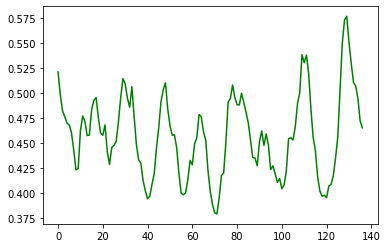

In [19]:
print(common_word_list[10]["word"])
print(redfern_rspk[2]["word"])
#print(redfern_word_list[1]["data"], redfern_rspk[2]["data"])
#print(np.float64(redfern_word_list[1]["data"]), np.float64(redfern_rspk[2]["data"]))
sweep_original = qbe.dtw_sweep(np.float64(common_word_list[10]["data"]), np.float64(redfern_rspk[2]["data"]))
plt.plot(sweep_original,color='green')
play(common_word_list[10]['audio'])
play(redfern_rspk[2]["audio"])

In [20]:
print(len(redfern_rspk))

112


In [21]:
def get_score(num_uttword, num_spotted, num_match, num_unspotted):
    word_recognition_rate = num_spotted/num_uttword
    precision = num_spotted/num_match
    recall = num_spotted/(num_spotted+num_unspotted)
    return word_recognition_rate, precision, recall

In [ ]:
from tqdm import tqdm
from statistics import mean
result = []
num_uttword = 0.01
num_spotted = 0.01 
num_prediction = 0.01
num_unspotted = 0.01
thres_distance = 0
common_words_penalty = 1.2
correct_dtw_score = []
incorrect_dtw_score = []

for uttr in range(0,len(redfern_rspk)):
    dic = {}
    dic['correct_words'] = []
    dic['incorrect_words'] = []
    dic['correct_dtw'] = []
    dic['incorrect_dtw'] = []
    match = set()
    close_words = set()
    for query in common_word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(redfern_rspk[uttr]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(redfern_rspk[uttr]['word'].lower())
        hasMatch = False
        dic['sentence'] = utt_sent                
                
        for utt_word in utt_sent:
            if lev.distance(query_word,utt_word)<=thres_distance:
                dic['correct_words'].append(utt_word)
                dic['correct_dtw'].append(min_dtw)
                correct_dtw_score.append(min_dtw)
                dic['time']=dtw_costs.index(min_dtw)*3/100
                print('{:<20}'.format(utt_word), end=' ')
                print('{:<20}'.format(query_word), end=' ')
                print("%0.3f" % min_dtw, end='\t')
                print(dic['time'])
                hasMatch = True
                #print('spotted_words:')
                #print(query_word,min_dtw)
                break
                
        if hasMatch == False:
            dic['incorrect_words'].append(query_word)
            dic['incorrect_dtw'].append(min_dtw)
            incorrect_dtw_score.append(min_dtw)
            #print('incorrect_words:')
            #print(query_word,min_dtw)        
        
    num_uttword += len(nltk.FreqDist(utt_sent))
    #num_prediction += len(match)
    num_spotted += len(dic['correct_words'])
    num_unspotted += len(dic['incorrect_words'])

#    print('Utterance: \t'+redfern_rspk[uttr]['word'])
#    print('Spotted Words:', end='\t')
#    for query_word ,word in close_words:
#        print('('+query_word+', '+word+')', end=' ')  
#    for word in dic['spotted_words']:
#        print(word, end=' ') 
#    print('\nFalse Positive:', end='\t')
#    for word in dic['incorrect_words']:
#        print(word, end=' ')
#    print('\nFailed to Spot:', end='\t')
#    for word in dic['unspotted_words']:
#        print(word, end=' ')
#    print('\n') 
    #word_recognition_rate, precision, recall = get_score(num_uttword, num_spotted, num_prediction, num_unspotted)     
    result.append(dic)
    print('\nCorrect DTW Average:', end=' ')
    print(mean(correct_dtw_score))
    print('Incorrect DTW Average:', end=' ')
    print(mean(incorrect_dtw_score))
    print('\n') 
    
print('\nCoverage: \t'+str(word_recognition_rate))
print('Precision: \t'+str(precision))
print('Recall: \t'+str(recall))
print('\n') 

and                  and                  0.307	0.84

Correct DTW Average: 0.307476463650474
Incorrect DTW Average: 0.3610350233189487


the                  the                  0.343	2.04
of                   of                   0.299	14.31
to                   to                   0.320	10.8
be                   be                   0.316	3.45
people               people               0.333	6.39
at                   at                   0.349	14.13
australia            australia            0.326	13.2
very                 very                 0.306	1.59
indigenous           indigenous           0.337	3.36
world                world                0.326	12.51
here                 here                 0.314	3.24
three                three                0.309	10.83
launch               launch               0.293	14.31
am                   am                   0.338	7.44
today                today                0.323	2.91
international        international        0.377	11.79
nineteen 

In [15]:
print(result[4]['spotted'])

{'strait', 'australia', 'torres', 'aboriginal', 'opportunity', 'people'}


In [14]:
print(num_uttword, num_spotted, num_prediction, num_unspotted)

1931.01 190.01 295.01 14.01


In [17]:
with open('redfern_rspk_topic_words.data', 'wb') as filehandle:
    pickle.dump(result, filehandle)